# Classification Between Group3+4 and Rest

## Required Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

## Data Preprocessing/Loading 

In [3]:
# load data
file_path = "features.csv"
df = pd.read_csv(file_path)
df.head()

,case,molecular,split,sex,age,t1_diagnostics_Versions_PyRadiomics,t1_diagnostics_Versions_Numpy,t1_diagnostics_Versions_SimpleITK,t1_diagnostics_Versions_PyWavelet,t1_diagnostics_Versions_Python,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,212716,shh,1,F,35.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.026191,0.000914,2512.151097,0.393754,0.651604,1918.935163,0.000685,8.103643,0.364780,73.645028
1,220204,group4,2,M,22.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.045723,0.002111,2670.044883,0.435783,0.686319,1419.813827,0.001417,7.934767,0.433004,18.896570
2,234406,group4,4,M,26.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.015780,0.001037,2894.365780,0.396815,0.654527,1759.160320,0.000632,8.058357,0.405493,17.069254
3,243030,shh,3,M,34.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,1.771472,0.000828,3931.643936,0.403784,0.660745,2215.427751,0.000581,8.079126,0.175195,8279.544143
4,248063,shh,0,M,37.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.617026,0.001642,1492.182540,0.370085,0.631286,848.080953,0.001149,7.561874,0.257143,613.609678


In [4]:
# obtain list of features selected from LASSO
# reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
# reduced_features = pd.read_excel(reduced_feats_path)
# reduced_features_list = reduced_features.loc[reduced_features['group3_rest'].isnull() == False,
#                                              ['group3_rest']].values.tolist()
# reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
# features_after_lasso = df[reduced_features_list]
sex_binarized = df['sex'].map(lambda sex: {'F': 0, 'M': 1}.get(sex, -1)).to_numpy()
df['sex'] = sex_binarized
df['age'] = df['age'].map(lambda x: 0 if pd.isna(x) else x)
# print(reduced_features_list)
reduced_features_list = [
    'sex', 'age',
                         't1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 't1_log-sigma-3-mm-3D_firstorder_Median', 't1_log-sigma-3-mm-3D_glcm_ClusterProminence', 't1_log-sigma-3-mm-3D_glrlm_LowGrayLevelRunEmphasis', 't1_log-sigma-5-mm-3D_glszm_GrayLevelVariance', 't1_original_glszm_LargeAreaHighGrayLevelEmphasis', 't1_original_glszm_LargeAreaLowGrayLevelEmphasis', 't1_original_shape_Flatness', 't1_wavelet-HHL_firstorder_Skewness', 't1_wavelet-HLL_firstorder_Mean', 't1_wavelet-HLL_glcm_Correlation', 't1_wavelet-LHL_glcm_Correlation', 't1_wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis', 't1_wavelet-LLL_firstorder_Skewness', 't1_wavelet-LLL_glszm_ZoneVariance', 't2_log-sigma-1-mm-3D_firstorder_Mean', 't2_log-sigma-1-mm-3D_firstorder_Median', 't2_log-sigma-1-mm-3D_glcm_Correlation', 't2_log-sigma-5-mm-3D_firstorder_Kurtosis', 't2_log-sigma-5-mm-3D_glrlm_RunLengthNonUniformity', 't2_log-sigma-5-mm-3D_glszm_SmallAreaEmphasis', 't2_original_glszm_GrayLevelNonUniformity', 't2_wavelet-HHH_glrlm_RunPercentage', 't2_wavelet-HHH_glszm_LargeAreaEmphasis', 't2_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis', 't2_wavelet-HHL_glcm_ClusterProminence', 't2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis', 't2_wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis', 't2_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 't2_wavelet-HLL_firstorder_Mean', 't2_wavelet-LHH_firstorder_Mean', 't2_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 't2_wavelet-LHL_glcm_Idn', 't2_wavelet-LLL_firstorder_Energy', 't2_wavelet-LLL_glcm_JointAverage', 't1_log-sigma-3-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 't1_wavelet-HHH_firstorder_Skewness', 't1_wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis', 't1_wavelet-HHL_glcm_ClusterProminence', 't1_wavelet-LHH_firstorder_Median', 't2_log-sigma-5-mm-3D_glcm_Imc2', 't2_original_glcm_Idmn', 't2_wavelet-LLL_firstorder_Median', 't2_wavelet-HHH_firstorder_Skewness', 't2_original_firstorder_Kurtosis', 't2_wavelet-LLL_firstorder_TotalEnergy']
print(len(reduced_features_list))
features_after_lasso = df[reduced_features_list]

48


In [5]:
# Binarizing target
target = df["molecular"]

# Marking 0 as rest and 1 group3+4
# mapping_dict = {0: 'rest', 1: 'group3'}
# target = target.map(dict(rest = 0, group3 = 1))
target = target.map({
    'wnt': 0,
    'shh': 0,
    'group3': 1,
    'group4': 1,
})
print(target.value_counts())

molecular
1    155
0    107
Name: count, dtype: int64


In [6]:
# Train/test split
train_idx = df['split'] != 'test'
test_idx = ~train_idx

X_train = features_after_lasso[train_idx]
X_test = features_after_lasso[test_idx]
y_train = target[train_idx]
y_test = target[test_idx]

# X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target,
#                                                     test_size = 0.25, random_state = 42)
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
molecular
1    123
0     79
Name: count, dtype: int64
TEST
molecular
1    32
0    28
Name: count, dtype: int64


### Resampling to Correct for Imbalance

In [7]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0]
X_1 = X[X['molecular'] == 1]

In [8]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled = pd.concat([upsampled_0, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [35]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())
print(X_train)

molecular
0    123
1    123
Name: count, dtype: int64
     sex   age  t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis   
135    1  11.0                                           0.004376         \
222    0   5.0                                           0.015072          
139    1  11.0                                           0.031277          
0      0  35.0                                           0.018039          
95     1   3.0                                           0.010039          
..   ...   ...                                                ...          
65     0  18.0                                           0.004293          
3      1  34.0                                           0.025112          
59     1  22.0                                           0.003257          
136    1   3.0                                           0.007687          
53     0  36.0                                           0.011107          

     t1_log-sigma-3-mm-3D_firstor

### Standardizing Features

In [10]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [36]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)
print(X_train)

          sex       age   
0    0.666737 -0.486718  \
1   -1.309374 -0.915099   
2    0.666737 -0.486718   
3   -1.309374  1.226808   
4    0.666737 -1.057893   
..        ...       ...   
241 -1.309374  0.013060   
242  0.666737  1.155411   
243  0.666737  0.298648   
244  0.666737 -1.057893   
245 -1.309374  1.298205   

     t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis   
0                                            -0.875045         \
1                                            -0.288504          
2                                             0.600109          
3                                            -0.125807          
4                                            -0.564514          
..                                                 ...          
241                                          -0.879595          
242                                           0.262047          
243                                          -0.936378          
244                      

In [12]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [13]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.4f} - {:0.4}]".format(name, 
    confidence_lower, confidence_upper))

In [14]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    return TN / (TN + FP) 
    #return round((TN / (TN + FP)),4) 

In [15]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return round((TP/(TP+FP)),4)

In [16]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    if TN + FN == 0:
        return np.nan
    
    return round((TN/(TN+FN)),4)        

In [17]:
def print_metrics(y_test, y_pred):
    from sklearn.metrics import precision_score
    def print_metric(metric_name, metric):
        for i, cls_name in enumerate(['WS', 'G34']):
            print(f"{metric_name} {cls_name} {metric(y_test, y_pred, pos_label=i):.8f}")
        print(f"{metric_name} macro {metric(y_test, y_pred, average='macro'):.8f}")
        print(f"{metric_name} micro {metric(y_test, y_pred, average='micro'):.8f}")
    print_metric('Precision', precision_score)
    print_metric('Recall', recall_score)
    print_metric('F1', f1_score)
    print(f"Acc Score: {accuracy_score(y_test, y_pred):.8f}")

In [18]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [19]:
def create_confusion_matrix(model_name, model, X, y):
    matrix = ConfusionMatrixDisplay.from_estimator(model, X, y,
                               cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

### User Defined Functions for Modeling

In [20]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    ret = grid.best_params_
    print(ret)
    return ret

### SVM

#### Grid Search for Hyperparameters

In [28]:
svm_model = svm.SVC()
svm_grid_params = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

# print(X_train)
svm_params = grid_search(svm_model, svm_grid_params, X_train, y_train)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


#### Model Performance

In [22]:
svm_model = svm.SVC(**svm_params, probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [23]:
print_metrics(y_test, y_pred)

Precision WS 0.00000000
Precision G34 0.53333333
Precision macro 0.26666667
Precision micro 0.53333333
Recall WS 0.00000000
Recall G34 1.00000000
Recall macro 0.50000000
Recall micro 0.53333333
F1 WS 0.00000000
F1 G34 0.69565217
F1 macro 0.34782609
F1 micro 0.53333333
Acc Score: 0.53333333


/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print(f"AUC: {auc}")

AUC: 0.7232142857142857


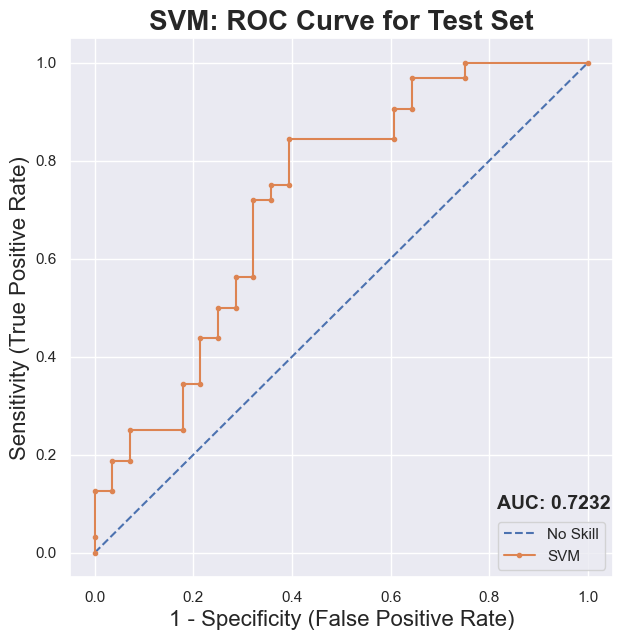

In [25]:
plot_roc_curve('SVM')

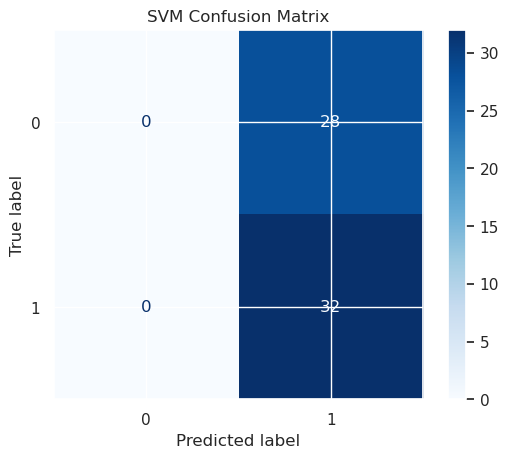

In [421]:
create_confusion_matrix('SVM', svm_model, X_test, y_test)

### Logistic Regression

#### Grid Search for Hyperparameters

In [29]:
lr_model = LogisticRegression()
lr_grid_params = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

lr_params = grid_search(lr_model, lr_grid_params, X_train, y_train)

{'C': 10, 'penalty': None}


/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.w

#### Model Performance

In [30]:
print(lr_params)
lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

{'C': 10, 'penalty': None}


/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [424]:
print_metrics(y_test, y_pred)

Precision WS 0.90909091
Precision G34 0.63265306
Precision macro 0.77087199
Precision micro 0.68333333
Recall WS 0.35714286
Recall G34 0.96875000
Recall macro 0.66294643
Recall micro 0.68333333
F1 WS 0.51282051
F1 G34 0.76543210
F1 macro 0.63912631
F1 micro 0.68333333
Acc Score: 0.68333333


In [456]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str.format('{0:.8f}',auc))

AUC: 0.69084821


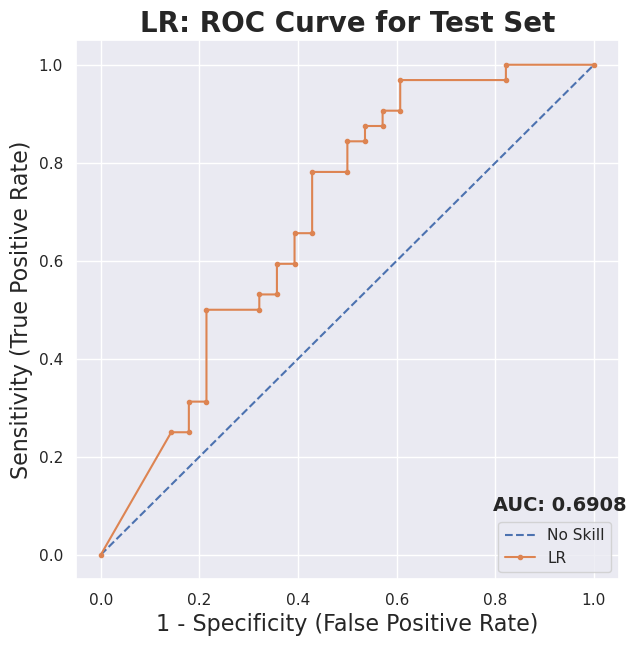

In [426]:
plot_roc_curve('LR')

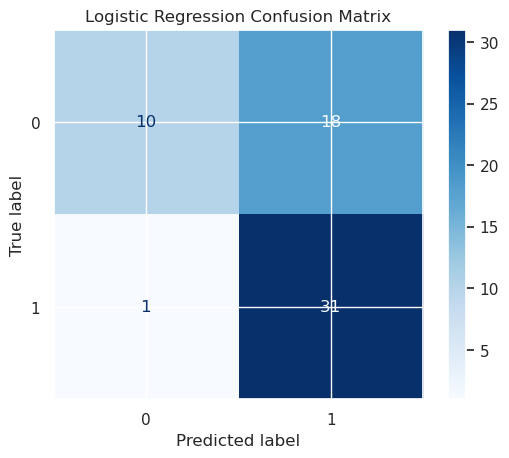

In [427]:
create_confusion_matrix('Logistic Regression', lr_model, X_test, y_test)

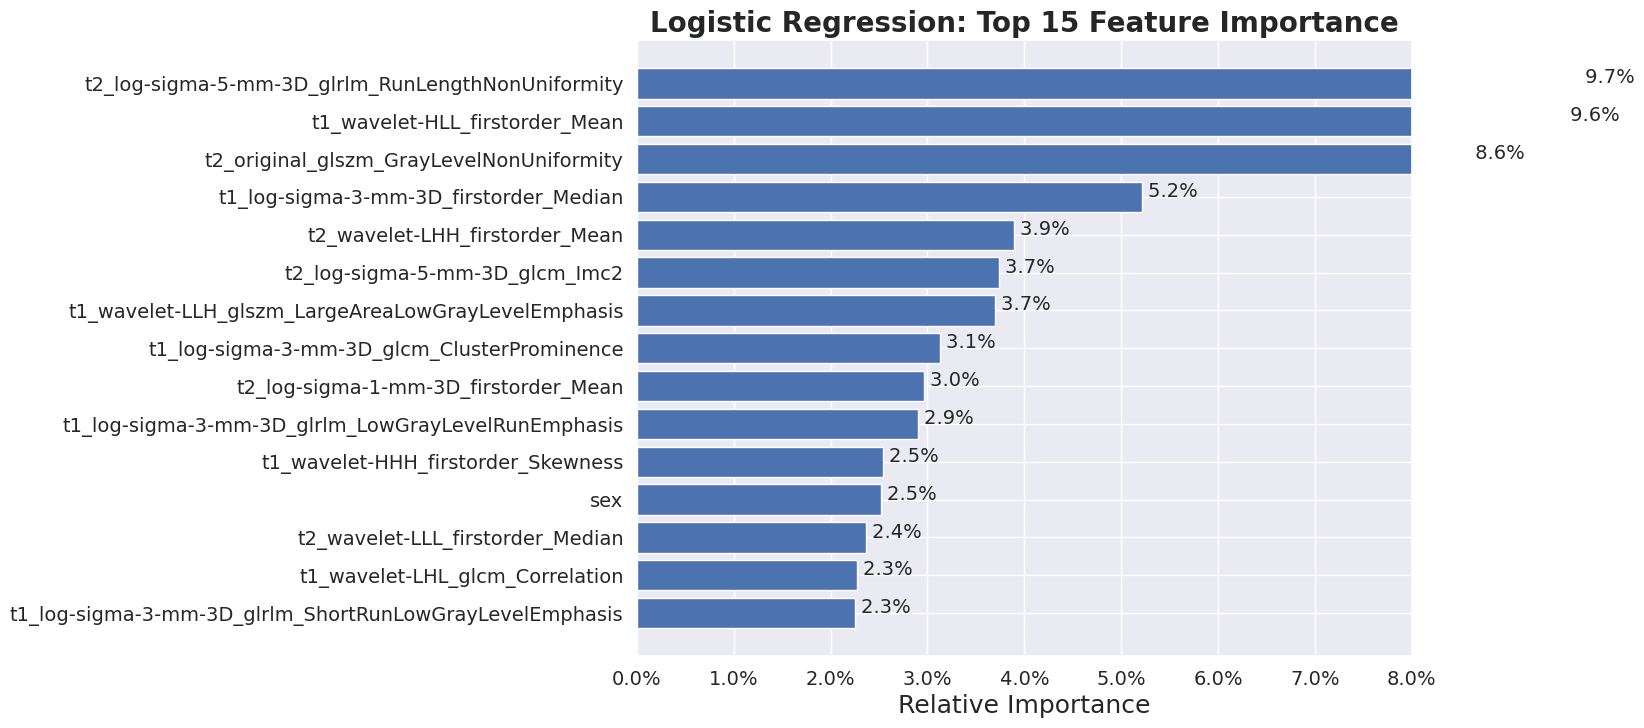

In [428]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Logistic Regression: Top 15 Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices[-15:])), importances[indices[-15:]], color='b', align='center')
plt.xlim(0, 0.08)
for index, value in enumerate(importances[indices[-15:]]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)

plt.yticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]], fontsize=14)

plt.xlabel('Relative Importance',fontsize=18)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xticks(fontsize=14)

plt.show()

Feature: 0, Score: 0.02254
Feature: 1, Score: 0.02269
Feature: 2, Score: 0.02371
Feature: 3, Score: 0.02522
Feature: 4, Score: 0.02543
Feature: 5, Score: -0.02904
Feature: 6, Score: 0.02965
Feature: 7, Score: -0.03134
Feature: 8, Score: 0.03701
Feature: 9, Score: -0.03736
Feature: 10, Score: 0.03889
Feature: 11, Score: -0.05212
Feature: 12, Score: -0.08587
Feature: 13, Score: 0.09566
Feature: 14, Score: 0.09727


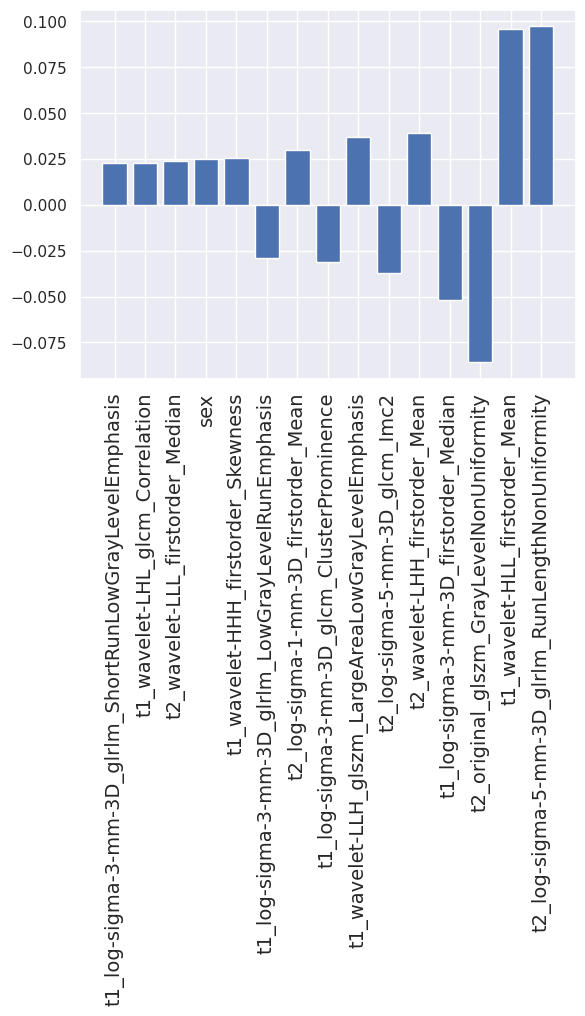

In [429]:
feature_names = X_test.columns.to_list()

importances_2 = lr_model.coef_[0]
importances_2 = (importances_2) / np.sum(np.abs(importances_2))

# summarize feature importance
for i,v in enumerate(importances_2[indices[-15:]]):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(indices[-15:]))], importances_2[indices[-15:]])
plt.xticks(range(len(indices[-15:])), [feature_names[i] for i in indices[-15:]], fontsize=14, rotation = 90)


plt.show()

### KNN

#### Grid Search for Hyperparameters

In [430]:
knn_model = KNeighborsClassifier()
knn_grid_params = {'n_neighbors': [3, 5, 7, 9]
}

knn_params = grid_search(knn_model, knn_grid_params, X_train, y_train)

{'n_neighbors': 3}


#### Model Performance

In [431]:
knn_model = KNeighborsClassifier(**knn_params)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [432]:
print_metrics(y_test, y_pred)

Precision WS 0.71428571
Precision G34 0.60869565
Precision macro 0.66149068
Precision micro 0.63333333
Recall WS 0.35714286
Recall G34 0.87500000
Recall macro 0.61607143
Recall micro 0.63333333
F1 WS 0.47619048
F1 G34 0.71794872
F1 macro 0.59706960
F1 micro 0.63333333
Acc Score: 0.63333333


In [457]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print(f"AUC: {auc:.8f}")

AUC: 0.61272321


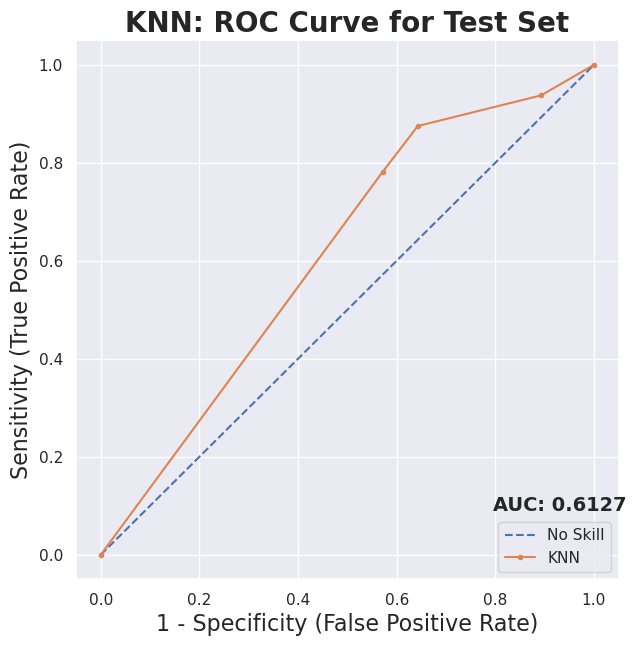

In [434]:
plot_roc_curve('KNN')

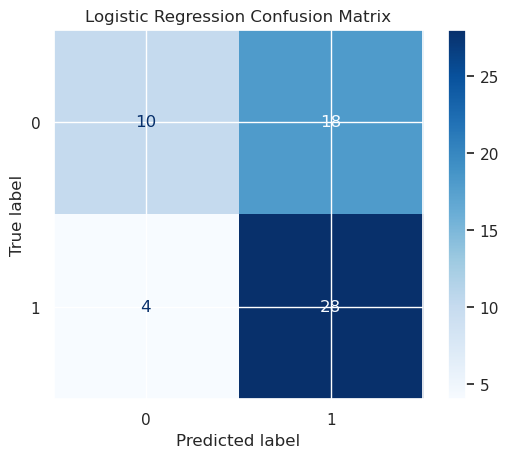

In [435]:
create_confusion_matrix('Logistic Regression', knn_model, X_test, y_test)

### Random Forest

#### Grid Search for Hyperparameters

In [436]:
rf_model = RandomForestClassifier(random_state = 42)
rf_grid_params = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_params = grid_search(rf_model, rf_grid_params, X_train, y_train)

{'max_depth': 4, 'n_estimators': 50}


/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/base.py", line 600, in _

#### Model Performance

In [437]:
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [438]:
print_metrics(y_test, y_pred)

Precision WS 1.00000000
Precision G34 0.60377358
Precision macro 0.80188679
Precision micro 0.65000000
Recall WS 0.25000000
Recall G34 1.00000000
Recall macro 0.62500000
Recall micro 0.65000000
F1 WS 0.40000000
F1 G34 0.75294118
F1 macro 0.57647059
F1 micro 0.65000000
Acc Score: 0.65000000


In [458]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print(f"AUC: {auc:.8f}")

AUC: 0.62946429


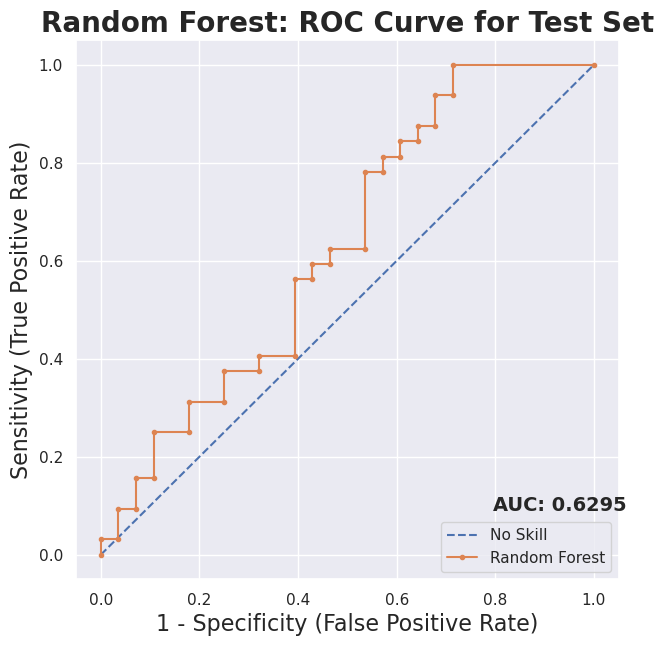

In [459]:
plot_roc_curve('Random Forest')

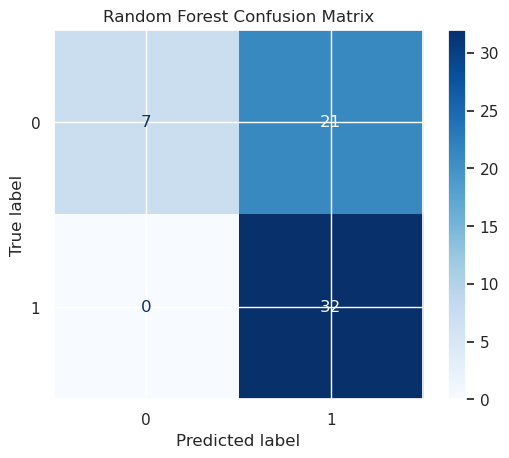

In [441]:
create_confusion_matrix('Random Forest', rf_model, X_test, y_test)

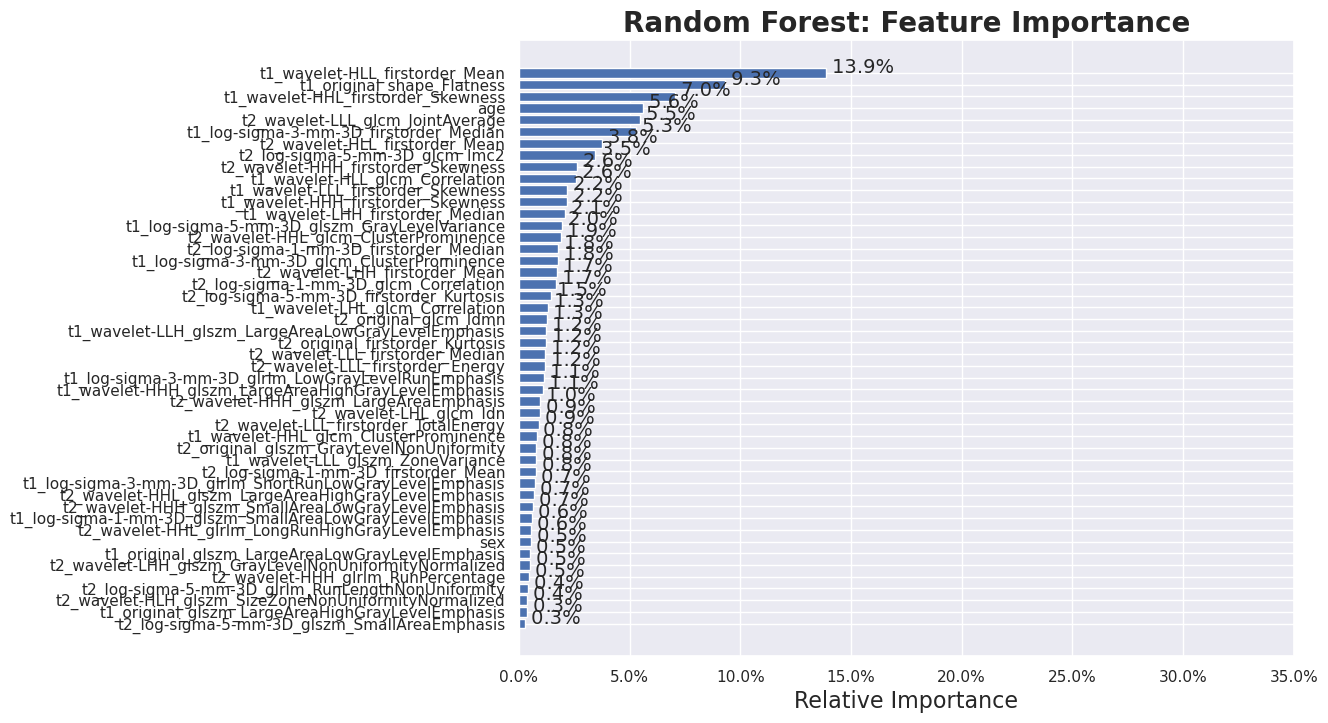

In [442]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Random Forest: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.35)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [38]:
xgb_model = XGBClassifier(random_state = 42)
xgb_grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}
print(X_train['t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis'])
xgb_params = grid_search(xgb_model, xgb_grid_params, X_train, y_train)

0     -0.875045
1     -0.288504
2      0.600109
3     -0.125807
4     -0.564514
         ...   
241   -0.879595
242    0.262047
243   -0.936378
244   -0.693480
245   -0.505933
Name: t1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis, Length: 246, dtype: float64
{'learning_rate': 0.1, 'max_depth': 4}


#### Model Performance

In [40]:
xgb_model = XGBClassifier(**xgb_params, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [445]:
print_metrics(y_test, y_pred)

Precision WS 0.87500000
Precision G34 0.59615385
Precision macro 0.73557692
Precision micro 0.63333333
Recall WS 0.25000000
Recall G34 0.96875000
Recall macro 0.60937500
Recall micro 0.63333333
F1 WS 0.38888889
F1 G34 0.73809524
F1 macro 0.56349206
F1 micro 0.63333333
Acc Score: 0.63333333


In [41]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str.format('{0:.8f}',auc))

AUC: 0.66629464


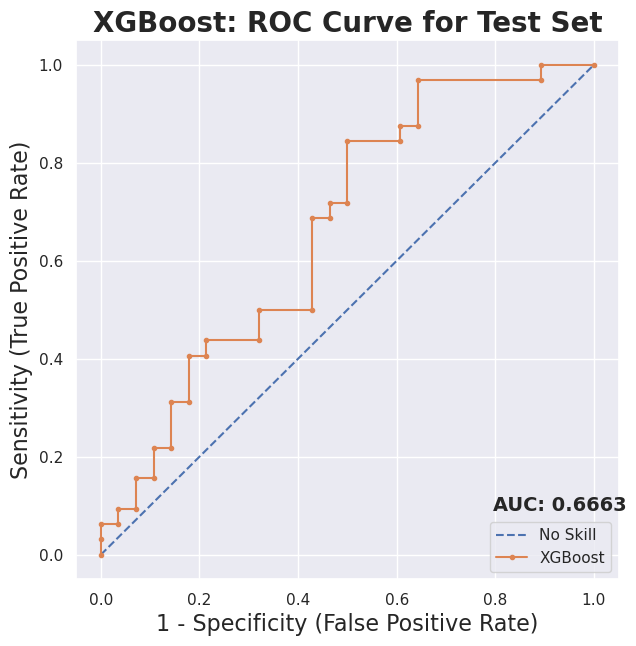

In [447]:
plot_roc_curve('XGBoost')

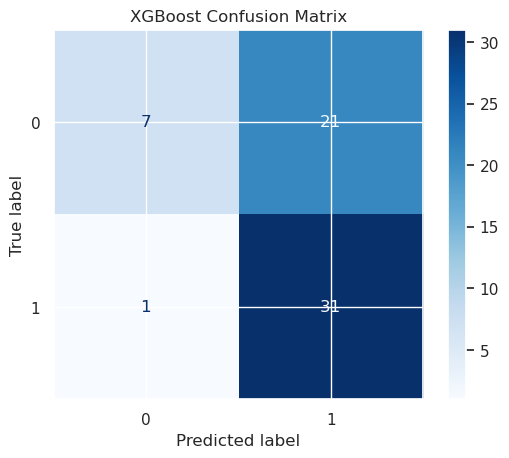

In [448]:
create_confusion_matrix('XGBoost', xgb_model, X_test, y_test)

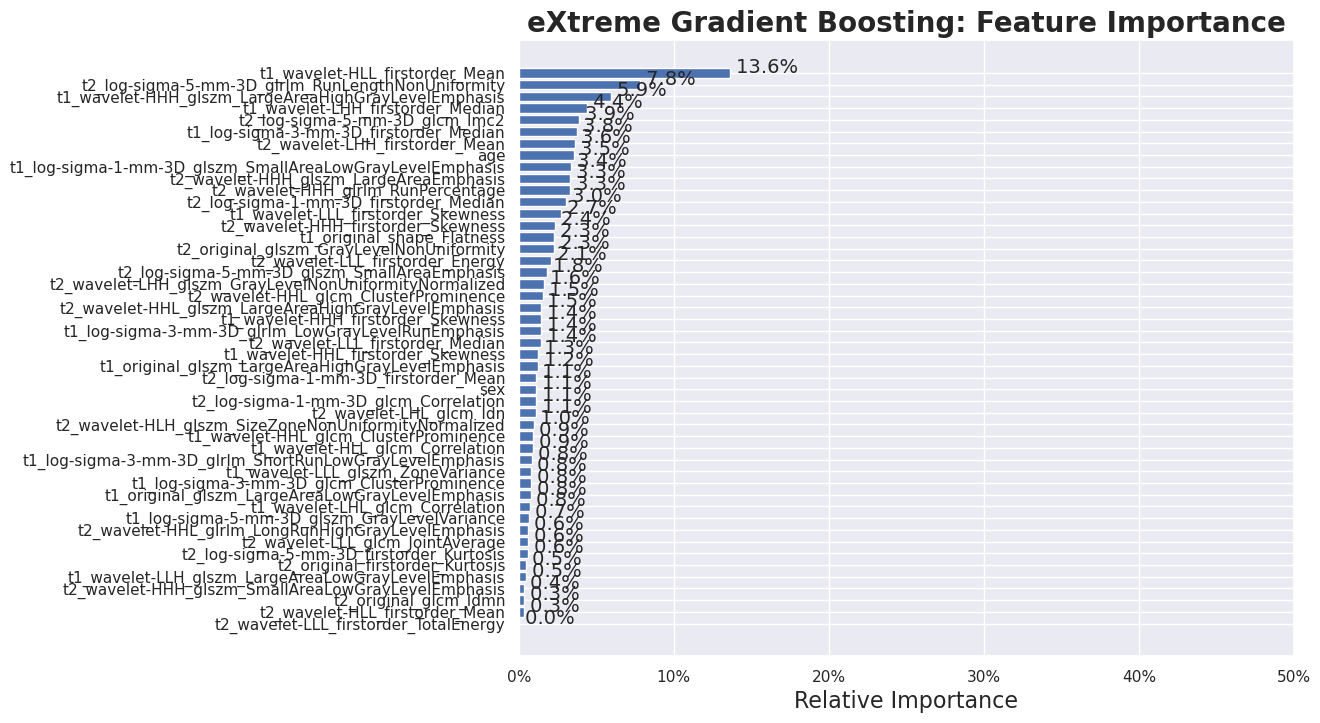

In [449]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('eXtreme Gradient Boosting: Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.5)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [450]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_params = grid_search(nn_model, nn_grid_params, X_train, y_train)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


#### Model Performance

In [451]:
nn_model = MLPClassifier(**nn_params, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [452]:
print_metrics(y_test, y_pred)

Precision WS 0.88888889
Precision G34 0.60784314
Precision macro 0.74836601
Precision micro 0.65000000
Recall WS 0.28571429
Recall G34 0.96875000
Recall macro 0.62723214
Recall micro 0.65000000
F1 WS 0.43243243
F1 G34 0.74698795
F1 macro 0.58971019
F1 micro 0.65000000
Acc Score: 0.65000000


In [461]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print(f"AUC: {auc:.8f}")

AUC: 0.60267857


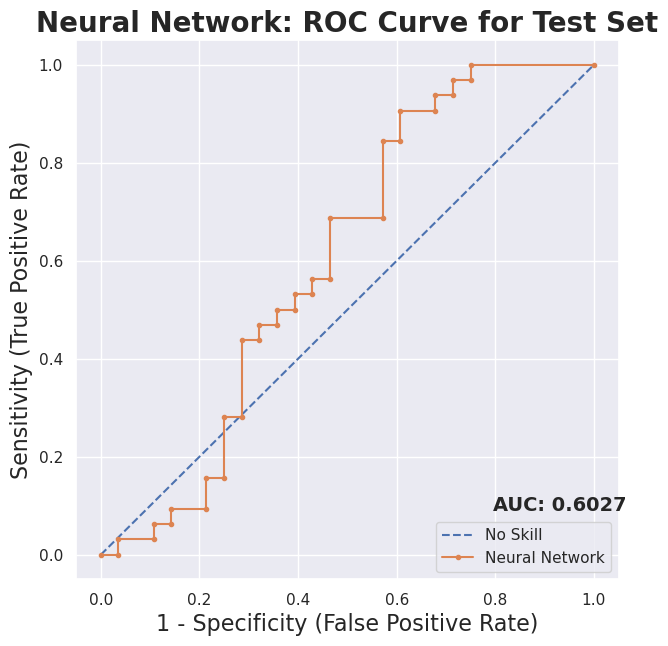

In [454]:
plot_roc_curve('Neural Network')

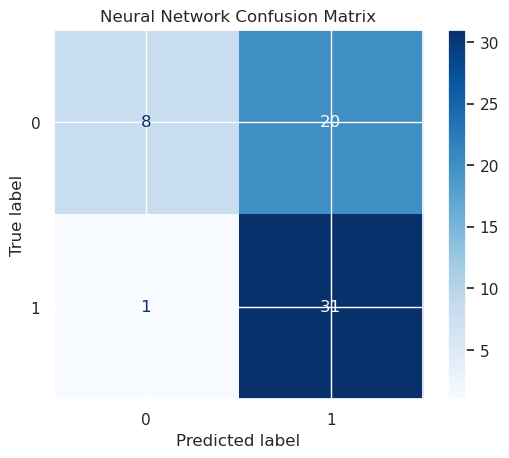

In [455]:
create_confusion_matrix('Neural Network', nn_model, X_test, y_test)